In [ ]:
!pip install -U pandarallel

# GENERAL IMPORTS

In [19]:
pip install pandarallel


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.1 MB/s eta 0:00:00
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16673 sha256=d2a504e8badf86b06615f947124443746a7f646fa03d1fa5b4ffd062f0c76784
  Stored in directory: /root/.cache/pip/wheels/50/4f/1e/34e057bb868842209f1623f195b74fd7eda229308a7352d47f
Successfully built pandarallel


In [20]:
from pandarallel import pandarallel


In [21]:
import numpy as np
import pandas as pd
from pandarallel import pandarallel

import os

# Todas las tablas deben encontrarse dentro de una carpeta llamada "data" ubicada
# en el directorio donde estamos trabajando!
files = {}
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        files[filename.split(".")[0]] = os.path.join(dirname, filename)


pandarallel.initialize(progress_bar=True)


INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Loading tables

In [ ]:
player_time = pd.read_csv(files["player_time"])
#objectives = pd.read_csv(files["objectives"])
#match_outcomes = pd.read_csv(files["match_outcomes"])
match = pd.read_csv(files['match'])
#player_ratings = pd.read_csv(files["player_ratings"])
players = pd.read_csv(files["players"])
purchase_log = pd.read_csv(files["purchase_log"])
hero_names = pd.read_csv(files["hero_names"])
teamfights = pd.read_csv(files['teamfights'])
#cluster_region = pd.read_csv(files["cluster_regions"])
#ability_upgrade=pd.read_csv(files['ability_upgrades'])
#chat = pd.read_csv(files["chat"])
#test_player = pd.read_csv(files["test_player"])
#ability_ids = pd.read_csv(files["ability_ids"])
#item_ids = pd.read_csv(files["item_ids"])
#test_labels = pd.read_csv(files["test_labels"])
#teamfights_players = pd.read_csv(files["teamfights_players"])
#patchs_dates = pd.read_csv(files["patch_dates"])

In [ ]:
hero_names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   name            112 non-null    object
 1   hero_id         112 non-null    int64 
 2   localized_name  112 non-null    object
dtypes: int64(1), object(2)
memory usage: 2.8+ KB


# Data preparation

## Get IDs from short matches
(will be removed on final DF)

In [ ]:
match_id_less_than_1200 = list(match[match["duration"] < 1200]["match_id"])

## Heroes per team

Heroes per team in dummies by match_id

FINAL DF = `heroes_per_team`

In [ ]:
players['radiant_player'] = players['player_slot'] < 50
#Este apply es lento, por eso use pandarallel (!pip install pandara)


In [ ]:
players["hero"] = players["hero_id"].parallel_apply(lambda x : str(hero_names[hero_names["hero_id"] == x]["localized_name"].values)[2:-2]) #No pude lograr extraer el valor solo, por eso el [2:-2]


In [ ]:
players["hero"] = players.apply(lambda x : x["hero"] + "_radiant" if x["radiant_player"] else x["hero"] + "_dire", axis=1)
display(players[["match_id","hero"]].head(10))
heroes_per_team = players[["match_id","hero"]]
heroes_per_team = pd.get_dummies(heroes_per_team, columns=["hero"]).groupby("match_id").sum()
heroes_per_team.head(3)

,match_id,hero
0,0,Rubick_radiant
1,0,Clockwerk_radiant
2,0,Treant Protector_radiant
3,0,Shadow Fiend_radiant
4,0,Spectre_radiant
5,0,Ember Spirit_dire
6,0,Abaddon_dire
7,0,Templar Assassin_dire
8,0,Earthshaker_dire
9,0,Alchemist_dire


,hero_Abaddon_dire,hero_Abaddon_radiant,hero_Alchemist_dire,hero_Alchemist_radiant,hero_Ancient Apparition_dire,hero_Ancient Apparition_radiant,hero_Anti-Mage_dire,hero_Anti-Mage_radiant,hero_Axe_dire,hero_Axe_radiant,...,hero_Winter Wyvern_dire,hero_Winter Wyvern_radiant,hero_Witch Doctor_dire,hero_Witch Doctor_radiant,hero_Wraith King_dire,hero_Wraith King_radiant,hero_Zeus_dire,hero_Zeus_radiant,hero__dire,hero__radiant
match_id,,,,,,,,,,,,,,,,,,,,,
0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Gold, Exp and lasthits

Gold, experience and lasthits from min 15 (900 secs) where used.

FINAL DF = `players_time_df_900`

In [ ]:
players_time_df = pd.read_csv('data/player_time.csv')
players_time_df_900 = players_time_df[players_time_df["times"] == 900].set_index("match_id")
players_time_df_900.head()

,times,gold_t_0,lh_t_0,xp_t_0,gold_t_1,lh_t_1,xp_t_1,gold_t_2,lh_t_2,xp_t_2,...,xp_t_129,gold_t_130,lh_t_130,xp_t_130,gold_t_131,lh_t_131,xp_t_131,gold_t_132,lh_t_132,xp_t_132
match_id,,,,,,,,,,,,,,,,,,,,,
0,900,3324,5,2914,5444,64,6117,2869,10,2971,...,4472,6534,114,7788,1767,6,1486,6470,60,3822
1,900,3184,16,3307,7849,110,8835,4041,15,3097,...,5266,3480,15,4586,4825,45,5591,4736,46,5198
2,900,3748,27,3855,4542,42,5571,5438,37,6076,...,4823,4698,47,5870,3128,10,2757,2214,5,2833
3,900,3687,10,4310,5598,49,4127,3915,26,5156,...,5546,2650,4,2511,2041,12,2131,5850,75,5730
4,900,7099,112,6938,7001,64,6732,3973,50,3241,...,2986,4171,23,3880,5576,72,5238,3292,37,3526


## Items purchases
Amount of items (each item id) bought by team

FINAL DF = `purchase_log_less_900_dire_radiant`

In [ ]:
#creo las columnas radiant_player y dire_player en función del valor de player_slot para reemplazar según ese valor

purchase_log['radiant_player'] = purchase_log['player_slot']
purchase_log['dire_player'] = purchase_log['player_slot']

In [ ]:
#reemplazo los valores de player_slot por 1s y 0s y ahora tenemos el dataset dividido en equipos
#controlo la imputación de los valores con los value_counts() y coinciden

purchase_log['radiant_player'] = purchase_log['radiant_player'].replace([0, 1, 2, 3, 4], 1)
purchase_log['radiant_player'] = purchase_log['radiant_player'].replace([128, 129, 130, 131, 132], 0)
purchase_log['dire_player'] = purchase_log['dire_player'].replace([0, 1, 2, 3, 4], 0)
purchase_log['dire_player'] = purchase_log['dire_player'].replace([128, 129, 130, 131, 132], 1)

In [ ]:
purchase_log_less_900 = purchase_log[purchase_log["time"] < 900]
print(purchase_log.shape)
print(purchase_log_less_900.shape)
purchase_log_less_900_radiant_player = purchase_log_less_900.groupby(["match_id","item_id"])["radiant_player"].sum().unstack(level="item_id").fillna(0)
purchase_log_less_900_dire_player = purchase_log_less_900.groupby(["match_id","item_id"])["radiant_player"].sum().unstack(level="item_id").fillna(0)
purchase_log_less_900_dire_radiant = purchase_log_less_900_radiant_player.join(purchase_log_less_900_dire_player, lsuffix='_radiant', rsuffix='_dire' )
print(purchase_log_less_900_dire_radiant.shape)
purchase_log_less_900_dire_radiant.head()

(18193745, 6)
(8936207, 6)
(50000, 286)


item_id,1_radiant,2_radiant,3_radiant,4_radiant,5_radiant,6_radiant,7_radiant,8_radiant,9_radiant,10_radiant,...,218_dire,220_dire,226_dire,229_dire,231_dire,235_dire,242_dire,247_dire,249_dire,254_dire
match_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,2.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## More Data to be added
...

# Dataframe Joins

In [ ]:
X = heroes_per_team.join(players_time_df_900).join(purchase_log_less_900_dire_radiant)
X = X.join(match[["match_id","radiant_win"]].set_index("match_id")) #add the y label
display(X.shape)
X_plot = X.copy() # This copy is used for future plots!

# Remove matches shorter than 20min (1200 secs)
X = X.drop(X.index[match_id_less_than_1200])
display(X.shape)

X = X.dropna()
display(X.shape)

y= X.pop("radiant_win")

display(X.shape)

# FIND NaNs
# display(X.isna().any())
# display(X.loc[X.isna().any(axis=1), X.isna().any()])

(50000, 540)

(49558, 540)

(49558, 540)

(49558, 539)

In [ ]:
X.shape

(49558, 539)

In [ ]:
y.shape

(49558,)

In [ ]:
df = X.copy()
df['radiant_win'] = y
df.to_csv('df_modelos.csv')

# Data Modeling

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df_modelo = pd.read_csv("/content/drive/MyDrive/portafolio_karen/Prediccion_Victorias_DOTA/df_modelos.csv")

In [7]:
df_modelo = df_modelo.set_index('match_id')


In [8]:
df_modelo.head(3)

,hero_Abaddon_dire,hero_Abaddon_radiant,hero_Alchemist_dire,hero_Alchemist_radiant,hero_Ancient Apparition_dire,hero_Ancient Apparition_radiant,hero_Anti-Mage_dire,hero_Anti-Mage_radiant,hero_Axe_dire,hero_Axe_radiant,...,220_dire,226_dire,229_dire,231_dire,235_dire,242_dire,247_dire,249_dire,254_dire,radiant_win
match_id,,,,,,,,,,,,,,,,,,,,,
0,1,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
1,0,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
2,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False


In [9]:
X = df_modelo.drop(columns = 'radiant_win')
y = df_modelo['radiant_win']

## Imports

In [18]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

import os

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold

from sklearn.model_selection import GridSearchCV
from sklearn import metrics

import seaborn as sns

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.3, random_state = 1237)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(34690, 539)
(14868, 539)
(34690,)
(14868,)


## PCA Decomposition

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import plotly.express as px


pca_obj = PCA()
pca_pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca_obj)])
pca_pipe.fit(X_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA())])

In [13]:
pca_analysis = pca_pipe.named_steps['pca']

Text(0, 0.5, 'Varianza cumulativa explicada')

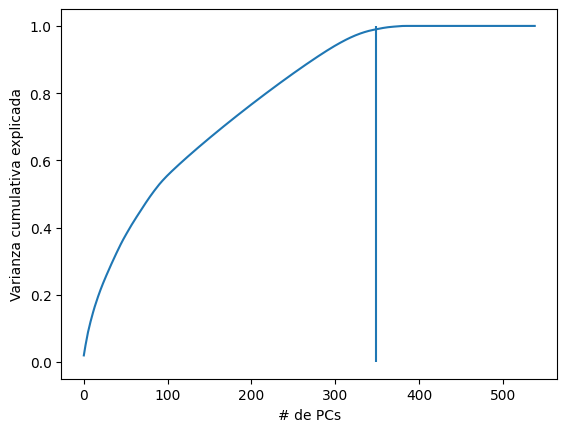

In [23]:
plt.plot(np.cumsum(pca_analysis.explained_variance_ratio_))
n_pc_99_varianza = np.where(np.cumsum(pca_analysis.explained_variance_ratio_) >= 0.99)[0][0]
plt.vlines(n_pc_99_varianza, 0, 1)
plt.xlabel("# de PCs")
plt.ylabel("Varianza cumulativa explicada")

In [24]:
pca = PCA(n_components=290)
pca_pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
pca_pipe.fit(X_train)
pca_analysis = pca_pipe.named_steps['pca']

Text(0, 0.5, 'Varianza cumulativa explicada')

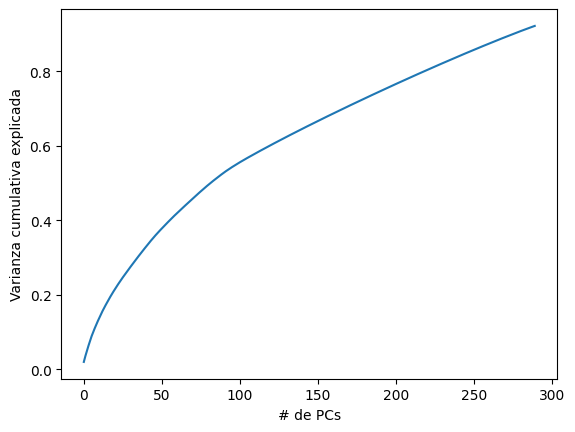

In [25]:
plt.plot(np.cumsum(pca_analysis.explained_variance_ratio_))
#n_pc_80_varianza = np.where(np.cumsum(pca_analysis.explained_variance_ratio_) >= 0.9)[0][0]
#plt.vlines(n_pc_80_varianza, 0, 1)
plt.xlabel("# de PCs")
plt.ylabel("Varianza cumulativa explicada")

In [26]:
X_train_pca_scaled = pca_pipe.transform(X_train)
print(X_train.shape, X_train_pca_scaled.shape)
X_test_pca_scaled = pca_pipe.transform(X_test)
print(X_test.shape, X_test_pca_scaled.shape)

(34690, 539) (34690, 290)
(14868, 539) (14868, 290)


## Naive Bayes

In [27]:
gnb = GaussianNB()
gnb_pca = GaussianNB()

gnb.fit(X_train, Y_train)
gnb_pca.fit(X_train_pca_scaled, Y_train)

GaussianNB()

In [28]:
print(X_test.shape, X_test_pca_scaled.shape)

Y_pred = gnb.predict(X_test)
Y_pred_pca = gnb_pca.predict(X_test_pca_scaled)

print(Y_pred.shape,Y_pred_pca.shape)

print(round(accuracy_score(Y_test, Y_pred), 2))
print(round(accuracy_score(Y_test, Y_pred_pca), 2))

(14868, 539) (14868, 290)
(14868,) (14868,)
0.61
0.54


In [29]:
from sklearn.metrics import roc_auc_score
gnb_auc = roc_auc_score(Y_test, gnb.predict(X_test))
print("El valor del AUC es: ", gnb_auc)

#PCA
gnb_auc_pca = roc_auc_score(Y_test, gnb_pca.predict(X_test_pca_scaled))
print("El valor del AUC es: ", gnb_auc_pca)

El valor del AUC es:  0.6153377984116505
El valor del AUC es:  0.5533823544439961


## Random Forest

In [30]:
#RandomForestClassifier?
rfc = RandomForestClassifier()
param_grid = {
    'n_estimators': [750,850,950],
    'max_features': ['auto'],
    'max_depth' : [50,60,75],
    'min_samples_split' : [3,4],
    'min_samples_leaf' : [2,3],
    'criterion' : ['entropy']
}

In [ ]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5, n_jobs=-1)

CV_rfc.fit(X_train, Y_train)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_depth': [50, 60, 75],
                         'max_features': ['auto'], 'min_samples_leaf': [2, 3],
                         'min_samples_split': [3, 4],
                         'n_estimators': [750, 850, 950]})

In [ ]:
print(CV_rfc.best_params_)

{'criterion': 'entropy', 'max_depth': 60, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 850}


### normal

In [ ]:
rf = RandomForestClassifier(criterion='entropy', max_depth= 80, max_features= 'auto', min_samples_leaf= 3, min_samples_split= 5, n_estimators= 700)
rf.fit(X_train, Y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomForestClassifier(criterion='entropy', max_depth=80, max_features='auto',
                       min_samples_leaf=3, min_samples_split=5,
                       n_estimators=700)

In [ ]:
y_pred = rf.predict(X_test)

In [ ]:
metrics.accuracy_score(Y_test, y_pred)

0.6974038202851762

### PCA dataframe

In [ ]:
CV_rfc_pca = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5, n_jobs=-3)
CV_rfc_pca.fit(X_train_pca_scaled, Y_train)

In [ ]:
print(CV_rfc_pca.best_params_)

In [ ]:
rf_pca = RandomForestClassifier(criterion='entropy', max_depth= 75, max_features= 'auto', min_samples_leaf= 3, min_samples_split= 4, n_estimators= 750, n_jobs=-3)
rf_pca.fit(X_train_pca_scaled, Y_train)

In [ ]:
y_pred = rf_pca.predict(X_test_pca_scaled)

In [ ]:
metrics.accuracy_score(Y_test, y_pred)

# Extra
For plots use the `X_plot` dataframe, which has the y-label "radiant_win"

In [ ]:
X_plot["radiant_win"] = X_plot["radiant_win"].astype(int)

In [ ]:
X_plot['xp_radiant'] = X_plot[['xp_t_0','xp_t_1', 'xp_t_2','xp_t_3','xp_t_4']].sum(axis=1)
X_plot['xp_dire']    = X_plot[['xp_t_128','xp_t_129','xp_t_130', 'xp_t_131','xp_t_132']].sum(axis=1)

X_plot['gold_radiant'] = X_plot[['gold_t_0','gold_t_1', 'gold_t_2','gold_t_3','gold_t_4']].sum(axis=1)
X_plot['gold_dire']    = X_plot[['gold_t_128','gold_t_129','gold_t_130', 'gold_t_131','gold_t_132']].sum(axis=1)

X_plot['lh_radiant'] = X_plot[['lh_t_0','lh_t_1', 'lh_t_2','lh_t_3','lh_t_4']].sum(axis=1)
X_plot['lh_dire']    = X_plot[['lh_t_128','lh_t_129','lh_t_130', 'lh_t_131','lh_t_132']].sum(axis=1)

X_plot[['xp_radiant', 'xp_dire', 'radiant_win', 'gold_radiant', 'gold_dire', 'lh_radiant', 'lh_dire']]


In [ ]:
import plotly.express as px
fig = px.scatter_3d(X_plot, x='lh_radiant', y='gold_radiant', z='xp_radiant',
              color=X_plot['radiant_win'].astype('str'))
fig.show()

# XGBoost

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
cv = StratifiedKFold(n_splits=5, random_state=41, shuffle=True)

In [ ]:
from xgboost.sklearn import XGBClassifier
model_xgb = XGBClassifier(n_jobs=-1, use_label_encoder=False)

In [ ]:
from sklearn.model_selection import GridSearchCV
params = {
    "n_estimators": [50,100,500],      # Number of boosted trees to fit.
    "max_depth": [1,2,3,4],            # Maximum tree depth for base learners.
    "learning_rate": [0.01, 0.1],      # Boosting learning rate
}

In [ ]:
xgb = GridSearchCV(model_xgb, param_grid=params, cv=cv, verbose=1, n_jobs=-1)

In [ ]:
xgb.fit(X_train,Y_train)

In [ ]:
xgb.best_params_

In [ ]:
def evaluar_rendimiento(modelo, nombre, X, y, cv):
    s = cross_val_score(modelo, X, y, cv=cv, n_jobs=-1)
    print("Rendimiento de {}:\t{:0.3} ± {:0.3}".format( \
        nombre, s.mean().round(3), s.std().round(3)))

In [ ]:
evaluar_rendimiento(xgb.best_estimator_,"XG Boost", X_train, Y_train, cv)


In [ ]:
from sklearn.metrics import roc_auc_score
xgb_auc = roc_auc_score(y_test, xgb.predict(X_test))
print("El valor del AUC es: ", xgb_auc)

# XGBoost con 2do subset

In [ ]:
df_modelo2 = df_modelo.sample(frac=0.5, axis=0)
df_modelo2.shape

In [ ]:
df_modelo2.to_csv('df_modelo2.csv')

In [ ]:
X = df_modelo2.drop(columns = 'radiant_win')
y = df_modelo2['radiant_win']

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.3, random_state = 1237)


In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
cv = StratifiedKFold(n_splits=4, random_state=41, shuffle=True)

In [ ]:
#Para este modelo, tomamos los mejores hiperparámetros que Gridsearch nos había arrojado como best_params_
# en el XGBoost anterior y agregamos 1000 n_estimators y 3 a max_depth
# Cambiamos los folds de CV a 4 en lugar de los 5 anteriores
# A diferencia del modelo anterior que tomó 72 minutos para correr, este tomó solo 24 mins

params2 = {
    "n_estimators": [500,1000],      # Number of boosted trees to fit.
    "max_depth": [2,3],            # Maximum tree depth for base learners.
    "learning_rate": [0.1],      # Boosting learning rate (xgb’s “eta”)
}

In [ ]:
xgb = GridSearchCV(model_xgb, param_grid=params2, cv=cv, verbose=1, n_jobs=-1)

In [ ]:
xgb.fit(X_train,Y_train)

In [ ]:
xgb.best_params_

In [ ]:
def evaluar_rendimiento(modelo, nombre, X, y, cv):
    s = cross_val_score(modelo, X, y, cv=cv, n_jobs=-1)
    print("Rendimiento de {}:\t{:0.3} ± {:0.3}".format( \
        nombre, s.mean().round(3), s.std().round(3)))

In [ ]:
evaluar_rendimiento(xgb.best_estimator_,"XG Boost", X_train, Y_train, cv)

In [ ]:
xgb_auc = roc_auc_score(Y_test, xgb.predict(X_test))
print("El valor del AUC es: ", xgb_auc)

# ExtraTreesClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

et = ExtraTreesClassifier(n_estimators=1000, class_weight='balanced', n_jobs=-1)
et.fit(X_train, Y_train)

#importancias_et = et.feature_importances_


In [ ]:
et_auc = roc_auc_score(Y_test, et.predict(X_test))
print("El valor del AUC es: ", et_auc)

In [ ]:
importancias_et = et.feature_importances_
cant_features = X_train.shape[1]


In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.title("Importancia de los features en ExtraTrees")
plt.bar(range(cant_features), sorted(importancias_et), color = "r", align = "center")
plt.xticks(range(cant_features))
plt.xlim([-1, cant_features])
plt.show()
